Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Отлично, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* К сожалению проект требует небольших доработок. Однако, изменения не займут много времени.
* Также я добавил несколько советов. Пожалуйста, обрати на них внимание.
* Если возникнут вопросы, то задавай их в следующей ячейке. Жду новую версию проекта.

<div class="alert alert-block alert-warning">
Привет, спасибо за ревью
</div>

### <font color='orange'>Общее впечатление (ревью 2)</font>
* Часть ошибок тебе удалось исправить, молодец.
* Однако, осталась одна ошибка, но в прошлой версии я допустил опечатку в комментарии и вследствие этого мне не удалось корректно объяснить, что я имею в виду.
* Новые комментарии обозначены фразой "ревью 2".
* Отправляй новую версию проекта, как только будут готовы изменения.

### <font color='orange'>Общее впечатление (ревью 3)</font>
* После изменений проект улучшился и может быть зачтен.
* Такое может быть, что у линейной модели скор оказался хуже. Вероятнее всего это зависит от TimeSeriesSplit.
* Если <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">посомтреть</a> на то, как происходит разбиение, то мы можем сделать вывод, что линейная регрессия хорошо обучается на маленьких по объему обучающих данных, в отличии от тяжелых моделей.
* Удачи в дальнейшем обучении и будущих работах!

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Содержание
* [Подготовка данных](#prepare_data)
* [Анализ данных](#data_analysis)
* [Обучение моделей](#model_train)
* [Тестирование на данных](#model_test)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from collections import namedtuple

import time

RANDOM_STATE = 12345

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
ModelTimeAndRMSE = namedtuple('ModelTimeAndRMSE', ('fit_time', 'predict_time', 'rmse'))

In [3]:
def analyze_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()
    print('Индекс отсортирован в хронологическом порядке: ', df.index.is_monotonic)
    
def plot_time_series(df, title, xlabel, ylabel):
    df.plot(grid=True, legend=False, figsize=(11, 5), title=title)\
            .set(xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
def split_df(df, columns):
    return df.drop(columns=['num_orders']), df['num_orders']

def get_model_time_and_rmse(model, features_train, target_train, features_test=None, target_test=None):
    if features_test is None: 
        features_test = features_train
    if target_test is None: 
        target_test = target_train
    fit_start = time.time()
    model.fit(features_train, target_train)
    fit_time = time.time() - fit_start
    
    predict_start = time.time()
    predictions = model.predict(features_test)
    predict_time = time.time() - predict_start
    
    rmse = mean_squared_error(target_test, predictions) ** 0.5
    
    return ModelTimeAndRMSE(fit_time, predict_time, rmse)

<a name="process_data"></a>
## Подготовка данных

Загрузим и проанализируем данные

In [4]:
taxi_df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
analyze_df(taxi_df)

Количество стобцов: 1
Количество строк: 26496


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
Индекс отсортирован в хронологическом порядке:  True


Проведем ресемплирование данных по одному часу

In [5]:
taxi_df = taxi_df.resample('1H').sum()

Выведем минимальное и максимальное значение индекса

In [6]:
taxi_df.index.min(), taxi_df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка данных и ресемплинг проведены корректно.
</div>

<a name="data_analysis"></a>
## Анализ данных

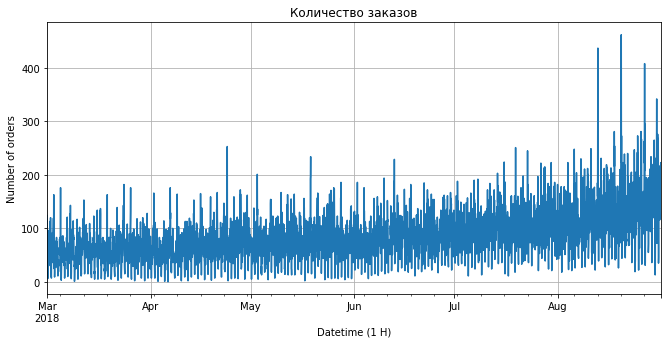

In [7]:
plot_time_series(taxi_df, 'Количество заказов', 'Datetime (1 H)', 'Number of orders')

Видно, что со временем количество заказов растет.
Выделим тренд, сезонную состовляющую и остаток при помощи декомпозиции

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что сам ряд был визуализирован.
</div>

In [8]:
decomposed = seasonal_decompose(taxi_df)

trend = decomposed.trend
seasonal = decomposed.seasonal
resid = decomposed.resid

Выведем графики для этих рядов

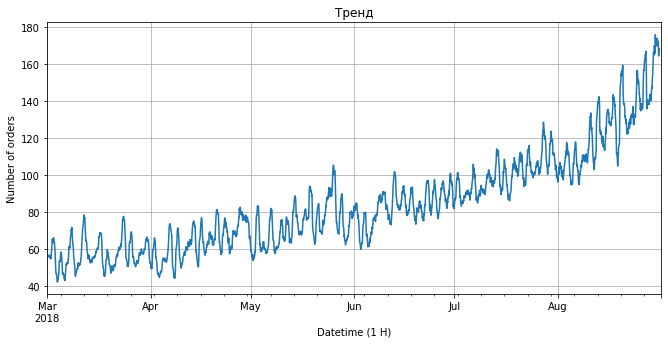

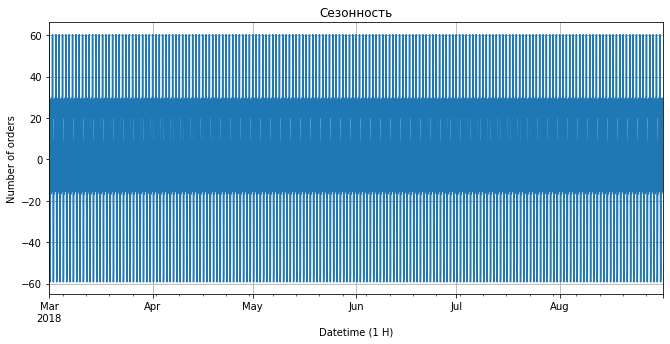

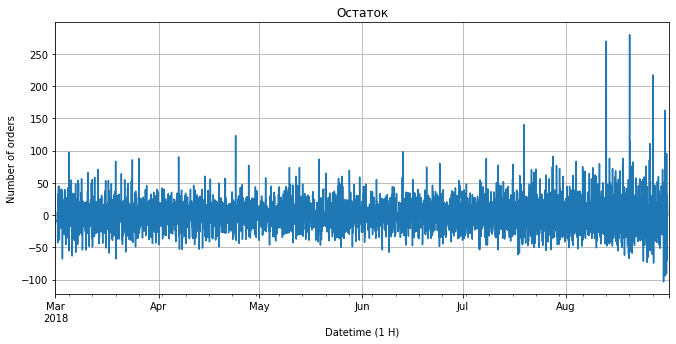

In [9]:
plot_time_series(trend, 'Тренд', 'Datetime (1 H)', 'Number of orders')
plot_time_series(seasonal, 'Сезонность', 'Datetime (1 H)', 'Number of orders')
plot_time_series(resid, 'Остаток', 'Datetime (1 H)', 'Number of orders')

Восходящий тренд означает рост количества заказов.  
На графике сезонности плохо видны данные за такой большой промежуток времени, поэтому выведем сезонность за будний день, выходной и за неделю 

In [10]:
seasonal.index.max()

Timestamp('2018-08-31 23:00:00')

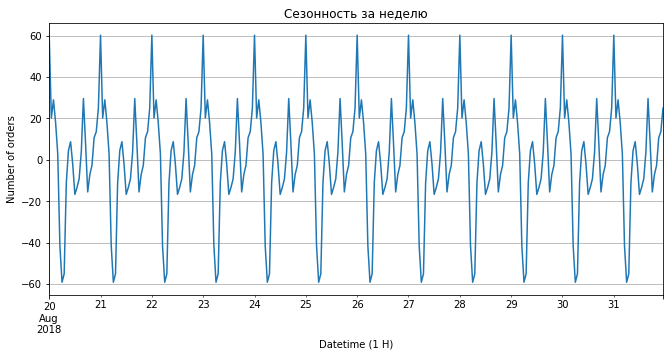

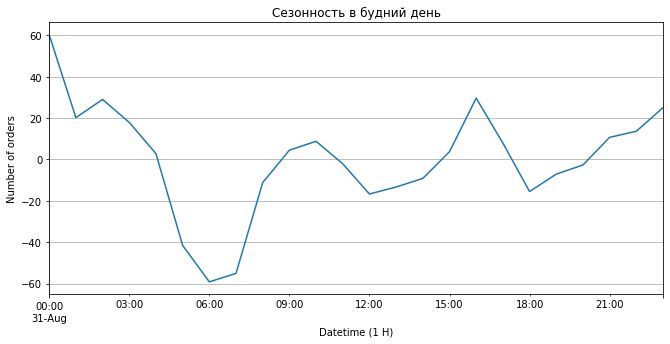

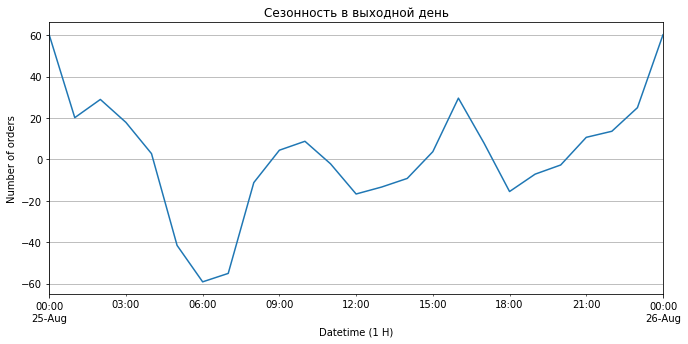

In [11]:
plot_time_series(
    seasonal.loc['2018-08-20 00:00:00':'2018-09-27 00:00:00'], 
    'Сезонность за неделю', 
    'Datetime (1 H)', 
    'Number of orders',
)
plot_time_series(
    seasonal.loc['2018-08-31 00:00:00':'2018-09-01 00:00:00'], 
    'Сезонность в будний день', 
    'Datetime (1 H)', 
    'Number of orders',
)
plot_time_series(
    seasonal.loc['2018-08-25 00:00:00':'2018-08-26 00:00:00'], 
    'Сезонность в выходной день', 
    'Datetime (1 H)', 
    'Number of orders',
)

Видно, что в течении буднего дня сезонность меняется: есть пики в начале и в конце рабочего дня.  
В выходной самый большой пик приходится на ночь, когда люди возвращаются с отдыха.  
В течении недели сезонность почти не меняется.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция проведена корректно. Радует, что сезонность была рассмотрена на более коротком интервале.
</div>

<a name="model_train"></a>
## Обучение моделей

Добавим календарные признаки: месяц и день, год добавлять не будем, поскольку у всех значений индекса он одинаковый

In [12]:
taxi_df['month'] = taxi_df.index.month
taxi_df['dayofweek'] = taxi_df.index.dayofweek
taxi_df['day'] = taxi_df.index.day

Определим функции для добавления фичей в датасет и проверку их качества 

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df_copy = df.copy()
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)

    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_copy = df_copy.dropna()
    
    return df_copy

def eval_features(df, max_lag, rolling_mean_size, model):  
    df_copy = make_features(df, max_lag, rolling_mean_size)
    
    features, target = split_df(df_copy, ['num_orders'])
    features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.2)
    
    model.fit(features_train, target_train)
    predictions = model.predict(features_test) 
    
    return mean_squared_error(target_test, predictions) ** 0.5

Найдем отстающие значения и скользящее среднее 

In [14]:
model = LinearRegression()
best_score = 10 ** 6
max_lag_best = None
rolling_mean_size_best = None

for max_lag in range(1, 50):
    for rolling_mean_size in range(1, 20):
        rmse = eval_features(taxi_df, max_lag, rolling_mean_size, model)
        if rmse < best_score: 
            best_score = rmse
            max_lag_best = max_lag
            rolling_mean_size_best = rolling_mean_size

print(best_score, max_lag_best, rolling_mean_size_best)

38.490057874637714 48 17


<div class="alert alert-block alert-info">
<b>Совет: </b> Не стоит собирать разные по смыслу функции в одну ячейку. Вообще определении функции и ее применение стоит разделять на разные ячейки.
</div>

<div class="alert alert-block alert-warning">
Перенес определение функций в отдельную ячейку 
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Подбор параметров производиться на тесте, а его результаты вообще не используются, зачем он нужен?
</div>

<div class="alert alert-block alert-warning">
Подбор параметров используется для того, чтобы потом добавить фичи на основе их в датасет.<br>
Тестовая выборка, которую я использую здесь не имеет отношения к тестовой выборке, на которой будет происходить тестирование итоговой модели.<br>
Идею для такого метода поиска параметров я брал из урока <a href="https://praktikum.yandex.ru/trainer/data-scientist/lesson/0d17784f-69e4-4b3d-a8bb-43c4e2a2b162/task/92f3c482-86d5-4cdd-a641-bdabc55959bf/">Временные ряды->Прогнозирование временных рядов->Обучение модели</a>
</div>

<div class="alert alert-block alert-info">
<b>Совет (ревью 2): </b> В прошлой версии результаты подбора параметров были другие, именно поэтому я и задал этот вопрос. Было: "38.52704231167729 8 3".
    <br> <br> По поводу подбора параметров. В обычной настройке параметров мы не используем тестовую выборку, чтобы избежать переобучения, то есть чрезмерной настройки на выборку. Так почему же эти параметры (lag и rolling size) не могу переподогнаться под конкретную выборку? Никакой разницы нет, какие параметры подбирать. Строго говоря, выбор конкретной модели (линейная или дерево) это точно такой же параметр.
</div>

In [15]:
taxi_df = make_features(taxi_df, 48, 17)
taxi_df.head(5)

,num_orders,month,dayofweek,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,5,3,72.0,119.0,101.0,93.0,49.0,89.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,65.588235
2018-03-03 01:00:00,108,3,5,3,163.0,72.0,119.0,101.0,93.0,49.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,74.764706
2018-03-03 02:00:00,25,3,5,3,108.0,163.0,72.0,119.0,101.0,93.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,78.411765
2018-03-03 03:00:00,64,3,5,3,25.0,108.0,163.0,72.0,119.0,101.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,77.235294
2018-03-03 04:00:00,44,3,5,3,64.0,25.0,108.0,163.0,72.0,119.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,77.823529


<div class="alert alert-block alert-warning">
Здесь можно увидеть, что я испольщую лучшие значения max_lag и rolling_mean_size для того, чтобы дбавить фичи в исходный датасет
</div>

Выделим фичи и целевой показатель `num_orders`

In [16]:
features, target = split_df(taxi_df, ['num_orders'])

Разделим данные на обучающую и тестовую выборку (на тестовую выборку выделим 10% данных)

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

Заведем массив, в который мы будем помещать результаты работы моделей

In [18]:
models_stats = []

Теперь можно перейти к обучению моделей

### LinearRegression

In [19]:
model = LinearRegression()
time_and_rmse = get_model_time_and_rmse(
    model, 
    features_train, 
    target_train, 
)
score = cross_val_score(model, features_train, target_train, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error').mean()
stats = {
    'model': 'LinearRegression',
    'fit_time': time_and_rmse.fit_time, 
    'predict_time': time_and_rmse.predict_time,
    'RMSE': time_and_rmse.rmse,
    'score': score, 
}
models_stats.append(stats)
print(stats)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


{'model': 'LinearRegression', 'fit_time': 0.163313627243042, 'predict_time': 0.11282849311828613, 'RMSE': 23.349598211855294, 'score': -644.4557454967598}


### CatBoost

In [20]:
model = CatBoostRegressor(random_seed=RANDOM_STATE, loss_function='RMSE', silent=True)

param_grid = {
    'learning_rate': [0.1, 0.01],
    'depth': [6, 8, 10],
    'iterations': [40, 60],
}

search_cb = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error', verbose=1)
search_cb.fit(features_train, target_train)

time_and_rmse = get_model_time_and_rmse(
    search_cb.best_estimator_, 
    features_train, 
    target_train, 
)
stats = {
    'model': 'CatBoost',
    'fit_time': time_and_rmse.fit_time, 
    'predict_time': time_and_rmse.predict_time,
    'RMSE': time_and_rmse.rmse,
    'score': search_cb.best_score_,
}
models_stats.append(stats)
print(stats)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.9min finished


{'model': 'CatBoost', 'fit_time': 4.441163778305054, 'predict_time': 0.01069498062133789, 'RMSE': 20.88100593834212, 'score': -705.4427049674722}


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации.
</div>

<div class="alert alert-block alert-warning">
Поменял на TimeSeriesSplit 
</div>

### RandomForestRegressor

In [21]:
model = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': range(10, 51, 10),
    'max_depth': range(2, 11, 1)
}

search_rf = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error', verbose=1)
search_rf.fit(features_train, target_train)

time_and_rmse = get_model_time_and_rmse(
    search_rf.best_estimator_, 
    features_train, 
    target_train, 
)
stats = {
    'model': 'RandomForestRegressor',
    'fit_time': time_and_rmse.fit_time, 
    'predict_time': time_and_rmse.predict_time,
    'RMSE': time_and_rmse.rmse,
    'score': search_rf.best_score_,
}
models_stats.append(stats)
print(stats)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.0min finished


{'model': 'RandomForestRegressor', 'fit_time': 4.7362220287323, 'predict_time': 0.033740997314453125, 'RMSE': 13.5195209508513, 'score': -683.2217590660208}


In [22]:
display(pd.DataFrame(models_stats))

,model,fit_time,predict_time,RMSE,score
0,LinearRegression,0.163314,0.112828,23.349598,-644.455745
1,CatBoost,4.441164,0.010695,20.881006,-705.442705
2,RandomForestRegressor,4.736222,0.033741,13.519521,-683.221759


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Почему ты сравниваешь модели по результатам на тестовой выборки? Используй сокр полученный из кросс-валидации.
</div>

<div class="alert alert-block alert-warning">
Не очень понял, я не использую на этом этапе тестовую выборку для вычисления RMSE и использую score полученный на кросс-валидации.<br> 
Если посмотреть в код функции get_model_time_and_rmse, то видно, что если не передать тестовую выборку, то вычисление RMSE будет проводиться по обучающей выборке 
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка (ревью 2):</b> Прошу прощения, я перепутал. В моем комменатрии выше слово "тестовая" надо заменить на "тренировочная". Ты передаешь в get_model_time_and_rmse лучшую модель, обучаешь ее на тренировочных данных(без кросс-валидации), и предсказываешь не тех же тренировочных данных, так как тестовые ты не передаешь. 
    <br><br> Получается, что ты используешь не скор полученный из валидации, а скор полученный на тренировочной выборке, а это не корректно.
    <br><br> Скор на валидации находится вот тут: "search_rf.best_score_float".
</div>

<a name="model_test"></a>
## Тестирование на данных 

Выберем лучшую модель (LinearRegression) и проверим метрику на тестовой выборке

In [23]:
model = LinearRegression()

model.fit(features_train, target_train)

predictions = model.predict(features_test)
print(mean_squared_error(target_test, predictions) ** 0.5)

43.25517091622006


**Вывод**: Получили значение RMSE 43.2 при использовании модели `LinearRegression`, что меньше чем трeбуемое в условии RMSE равное 48.

<div class="alert alert-block alert-success">
<b>Успех:</b> Этот шаг проведен корректно.
</div>

<div class="alert alert-block alert-warning">
Это нормально, что score у LinearRegression лучше, чем у остальных моделей, но RMSE на тестовой выборке хуже? 
</div>

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48